In [1]:
import NeuralTSNE as ntsne
import torch
from torch.utils.data import Subset, TensorDataset
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import Trainer
import numpy as np

In [2]:
train, test = ntsne.DatasetLoader.get_dataset("mnist")


d:\miniconda3\envs\test\Lib\site-packages\NeuralTSNE\DatasetLoader\get_datasets.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train = torch.load(dataset_name + "_trai

In [3]:
len(train), len(test)

(60000, 10000)

In [4]:
train_labels = train.targets
test_labels = test.targets

In [5]:
val = Subset(train, range(0, 10000))
train = Subset(train, range(10000, len(train)))

In [6]:
len(train), len(val), len(test)

(50000, 10000, 10000)

In [7]:
features = train.dataset[0][0].size(0)
reduced_features = 2
multipliers = [0.75, 0.5, 0.3]

In [8]:
basic_model = ntsne.TSNE.NeuralNetwork.NeuralNetwork(features, reduced_features, multipliers)

In [9]:
print(basic_model)

NeuralNetwork(
  (sequential_stack): Sequential(
    (0): Linear(in_features=784, out_features=588, bias=True)
    (ReLu0): ReLU()
    (1): Linear(in_features=588, out_features=392, bias=True)
    (ReLu1): ReLU()
    (2): Linear(in_features=392, out_features=235, bias=True)
    (ReLu2): ReLU()
    (3): Linear(in_features=235, out_features=2, bias=True)
  )
)


In [10]:
param_tsne = ntsne.TSNE.ParametricTSNE.ParametricTSNE(
    loss_fn="kl_divergence",
    n_components=reduced_features,
    perplexity=30,
    batch_size=1000,
    early_exaggeration_epochs=0,
    early_exaggeration_value=0,
    max_iterations=500,
    features=features,
    multipliers=multipliers,
    n_jobs=31,
)

In [11]:
print(param_tsne.model)

NeuralNetwork(
  (sequential_stack): Sequential(
    (0): Linear(in_features=784, out_features=588, bias=True)
    (ReLu0): ReLU()
    (1): Linear(in_features=588, out_features=392, bias=True)
    (ReLu1): ReLU()
    (2): Linear(in_features=392, out_features=235, bias=True)
    (ReLu2): ReLU()
    (3): Linear(in_features=235, out_features=2, bias=True)
  )
)


In [12]:
early_stopping = EarlyStopping(monitor="val_loss", min_delta=1e-5, patience=10)

In [13]:
trainer = Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    log_every_n_steps=1,
    max_epochs=param_tsne.max_iterations,
    callbacks=[early_stopping]
)

reducer = ntsne.TSNE.Modules.DimensionalityReduction(param_tsne, False, lr=1e-3)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
d:\miniconda3\envs\test\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [14]:
traind, testd = param_tsne.create_dataloaders(train, test)
vald, _ = param_tsne.create_dataloaders(val, None)

In [15]:
torch.set_float32_matmul_precision('high')

In [16]:
trainer.fit(reducer, traind, [vald])


  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | NeuralNetwork | 785 K  | train
------------------------------------------------
785 K     Trainable params
0         Non-trainable params
785 K     Total params
3.141     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\miniconda3\envs\test\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
Calculating P: 100%|██████████| 10/10 [00:07<00:00,  1.28batch/s]


d:\miniconda3\envs\test\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Calculating P: 100%|██████████| 50/50 [00:39<00:00,  1.26batch/s]

Epoch 0:   8%|▊         | 4/50 [00:00<00:02, 21.67it/s, v_num=3, train_loss_step=3.300]

Epoch 30: 100%|██████████| 50/50 [00:02<00:00, 16.76it/s, v_num=3, train_loss_step=1.050, val_loss_step=1.360, val_loss_epoch=1.410, train_loss_epoch=1.230]


In [17]:
Y = trainer.predict(reducer, testd)

d:\miniconda3\envs\test\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 33.61it/s]


In [18]:
#convert predict batches to numpy
Y = np.concatenate(Y, axis=0)

In [19]:
Y.shape

(10000, 2)

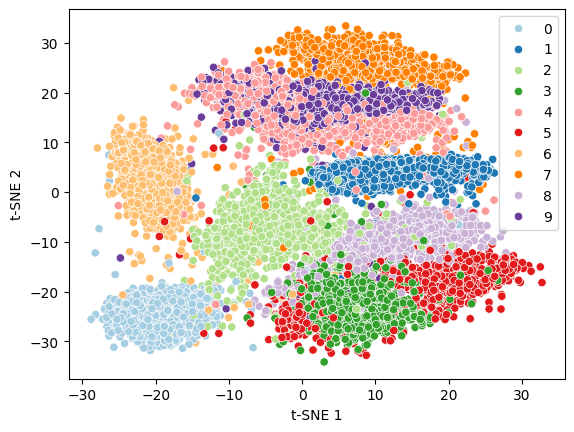

In [20]:
ntsne.MnistPlotter.plot(Y, test_labels)